# Fused Formulation Tutorial

This tutorial goes over the $D$ and $\beta$ hyperparameters of the UCOOT and UGW procedures, which allow for the use of prior knowledge during alignment. By solving another optimal transport problem between a supervision matrix and the sample/feature coupling matrix at the same time as UCOOT or UGW, the fused formulation ($D$ and $\beta$) allows us to manipulate our coupling matrices, as we will see in this tutorial. We use the CITE-seq dataset again in this tutorial (trying to recover the 1-1 alignments) and mostly focus on UCOOT alignments.

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virtual environment, continue on here.

If you are unsure how to initialize a Solver object, view our setup tutorial to get a sense for how to trade speed and accuracy using its constructor parameters.

If the notation and problem formulation seem confusing, try viewing our document on the theory of optimal transport to get more comfortable first.

If you want a more gradual intro into this tool, start with our UGW or UCOOT tutorials.

If you are already comfortable with the fused formulation, continue on to the AGW tutorial, which ties together everything we have looked at thus far.
```

### Data Download

As in previous tutorials, we provide preprocessed data on the 1000 cells we will be working with. However, if you would like to do the preprocessing yourself (for example, following the steps in Tran et al.) and do not already have the ADT and RNA files downloaded from the CITE-seq dataset, run the following commands in the terminal in the root directory of this tutorial repository:

<center> sh ./download_scripts/CITEseq_download.sh </center>

If you have not modified our original directory structure for the data, these files will be downloaded into the same folder as the preprocessed datasets.

### Preprocessing

We follow the same setup tasks as we have in the past few tutorials, ending with visualization of our two pre-alignment domains.

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.1.0
CUDA available: False
CUDA version: None
CUDNN version: None


First, we read in the data.

In [3]:
%%capture
from scotplus.solvers import SinkhornSolver
from scotplus.utils.alignment import compute_graph_distances, get_barycentre, FOSCTTM
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import normalize
plt.rcParams['font.family'] = 'Helvetica Neue'

adt_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
rna_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
adt_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]
rna_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(adt_raw.shape[1])]

```{note}
As in the prior tutorials, we examine a subset of 10 of the 25 gene-antibody pairs.
```

In [4]:
# l2 normalization of both datasets, which we found to help with single cell applications
adt = pd.DataFrame(normalize(adt_raw.X.transpose()))
rna = pd.DataFrame(normalize(rna_raw.X.transpose()))

# annotation of both domains
adt.index, adt.columns = samp_labels, adt_feat_labels
rna.index, rna.columns = samp_labels, rna_feat_labels


We now visualize our two domains; these visualizations are useful for later comparison with aligned data.

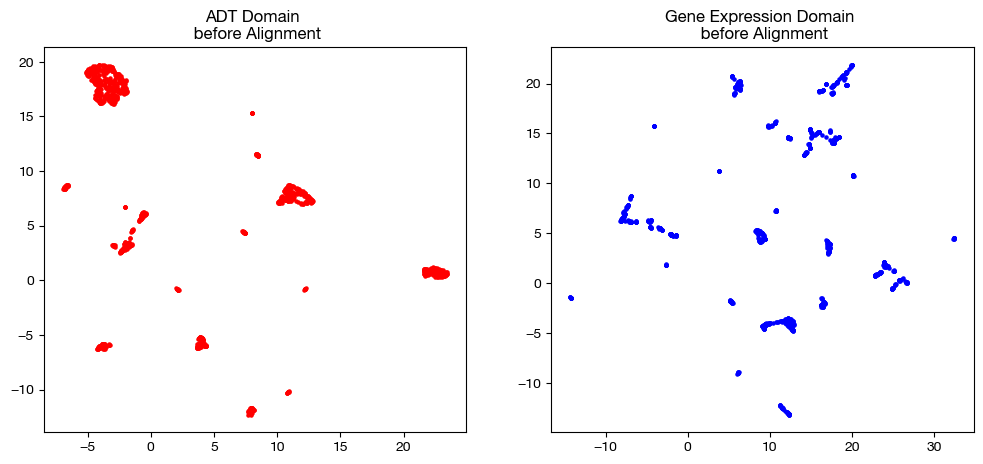

In [5]:
# we fit these objects now, and use them to transform our aligned data later on
adt_um = umap.UMAP(random_state=0, n_jobs=1)
rna_um = umap.UMAP(random_state=0, n_jobs=1)

adt_um.fit(adt.to_numpy())
rna_um.fit(rna.to_numpy())

original_adt_um=adt_um.transform(adt.to_numpy())
original_rna_um=rna_um.transform(rna.to_numpy())

# visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(original_rna_um[:,0], original_rna_um[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

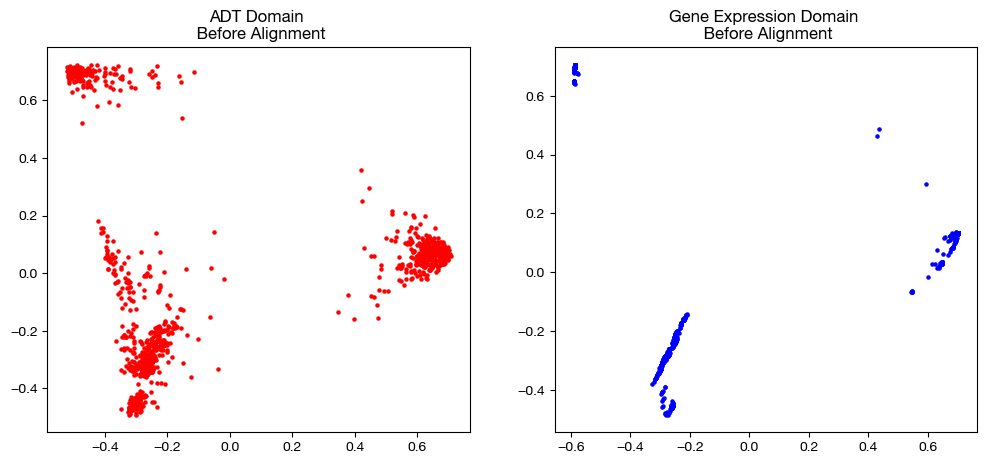

In [6]:
from sklearn.decomposition import PCA

# again, we fit these now so that we can transform our aligned data later on
adt_pca=PCA(n_components=2)
rna_pca=PCA(n_components=2)

adt_pca.fit(adt.to_numpy())
rna_pca.fit(rna.to_numpy())

original_adt_pca=adt_pca.transform(adt.to_numpy())
original_rna_pca=rna_pca.transform(rna.to_numpy())

# visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12,5))
ax1.scatter(original_adt_pca[:,0], original_adt_pca[:,1], c="r", s=5)
ax1.set_title("ADT Domain \n Before Alignment")
ax2.scatter(original_rna_pca[:,0], original_rna_pca[:,1], c="b", s=5)
ax2.set_title("Gene Expression Domain \n Before Alignment")
plt.show()

### Default Fused Formulation

With the data loaded and preprocessed, we can begin by instantiating a Solver object, as in the case of regular UCOOT or UGW:

In [7]:
scot = SinkhornSolver(nits_uot=5000, tol_uot=1e-3, device=device)

Now, we can try using $D$ and $\beta$. First, note that $D$ is a tuple, ($D_s$, $D_f$); so is $\beta$: ($\beta_s$, $\beta_f$). In addition to all of our usual regularization terms (entropic/marginal relaxation) added to the objective function (transport cost), we now add the inner product of $D_x$ and $\pi_x$, multiplied by $\beta_x$, for both $x = s$ and $x = f$. So, $\beta$ tells us how much to consider this part of the cost function, while $D$ tells us more about what this part of the cost function is really doing. By adding the inner product of $D$ and $\pi$ for each coupling matrix to the cost, we penalize various cells in $\pi$ based on our entries in $D$. For example, if $D_{s_{0,0}} = 0$, then when we add $\beta_s \langle D_s, \pi_s \rangle$ to the cost function, $\pi_{s_{0,0}}$ is not penalized; i.e. there is no extra penalty to transporting mass from sample 0 in domain 1 to sample 0 in domain 2. On the other hand, if we put a positive value at some cell in either $D$ matrix, the equivalent cell in the $\pi$ matrix will be penalized. By adding $D$ as a hyperparameter, we can now penalize (or not penalize) aligning certain samples or features directly, using our prior knowledge. In addition, we can scale how we use this knowledge through modification of $\beta$. Let's begin by trying a few different values of $\beta$, where we initialize $D_s$ and $D_f$ to have all 1s off diagonal and all 0s on the diagonal (encouraging matches along the diagonal). Note that we are incorporating prior knowledge here, as we know that the genes and antibodies on the diagonal should match up, and so should the samples, per Tran et al.

In [11]:
D_feat = torch.from_numpy(-1*np.identity(25, dtype='float32') + np.ones((25, 25), dtype='float32')).to(device)
D_samp = torch.from_numpy(-1*np.identity(1000, dtype='float32') + np.ones((1000, 1000), dtype='float32')).to(device)

pi_samp_sm, _, pi_feat_sm = scot.ucoot(rna, adt, eps=1e-3, rho=(1,1), beta=(1e-3, 1e-3), D=(D_samp, D_feat), verbose=False)

pi_samp_med, _, pi_feat_med = scot.ucoot(rna, adt, eps=1e-3, rho=(1,1), beta=(1e-2, 1e-2), D=(D_samp, D_feat), verbose=False)

pi_samp_lg, _, pi_feat_lg = scot.ucoot(rna, adt, eps=1e-3, rho=(1,1), beta=(1e-1, 1e-1), D=(D_samp, D_feat), verbose=False)

In [12]:
aligned_rna_sm = get_barycentre(adt, pi_samp_sm)
aligned_rna_med = get_barycentre(adt, pi_samp_med)
aligned_rna_lg = get_barycentre(adt, pi_samp_lg)

Now that we have our alignments, we can see how the different values of $\beta$ changed the UCOOT performance. Note that we expect to see a perfect alignment when is $\beta$ large, as we assigned no cost to any of the correct aligments in the $D_s$ matrix, and cost to all of the incorrect alignments. However, when $\beta$ is small, this bonus may be less of a factor than the transport or regularization costs.

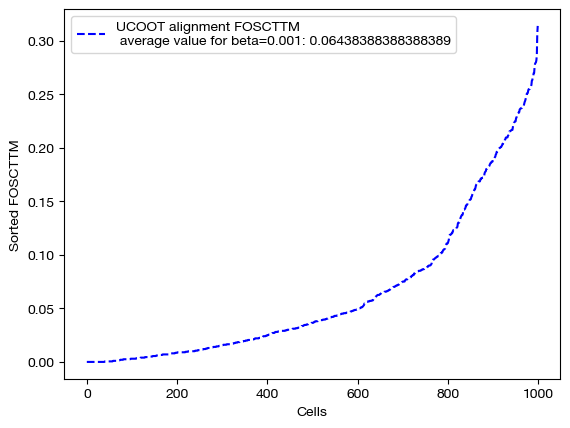

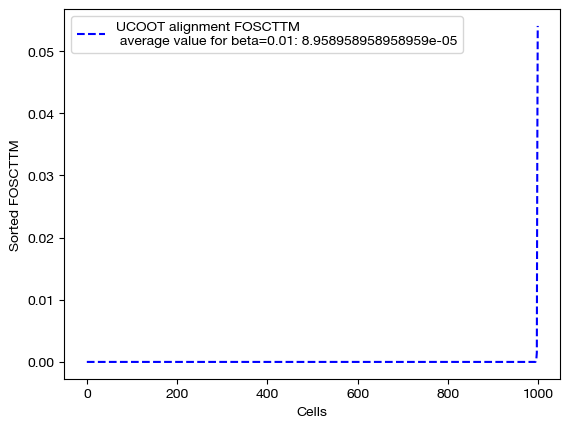

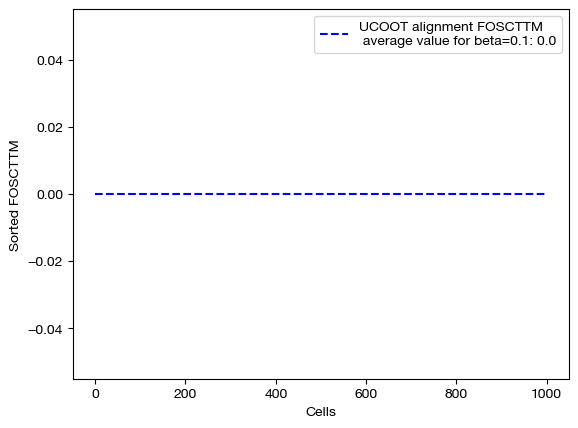

In [13]:
for aligned_rna, size in [(aligned_rna_sm, 'beta=0.001'), (aligned_rna_med, 'beta=0.01'), (aligned_rna_lg, 'beta=0.1')]:
    fracs = FOSCTTM(adt, aligned_rna.numpy())
    legend_label="UCOOT alignment FOSCTTM \n average value for {0}: ".format(size)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

As predicted, increasing $\beta$ moves us from the standard alignment with these hyperparameters towards a perfect alignment. Now, we can look at the matrices themselves:

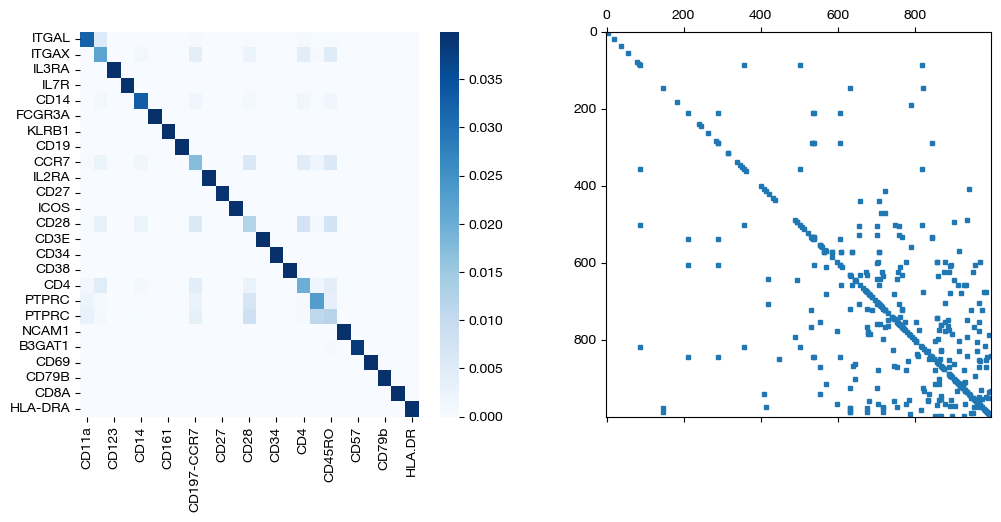

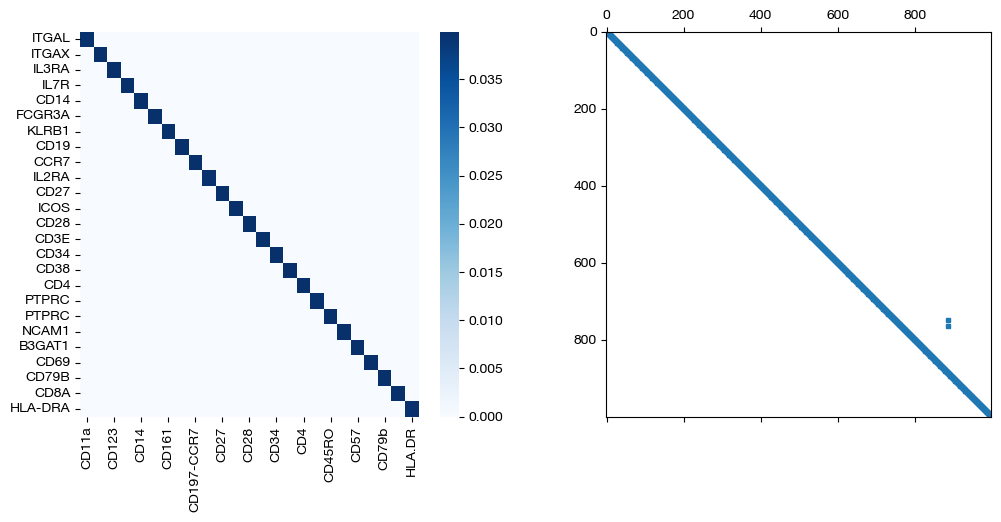

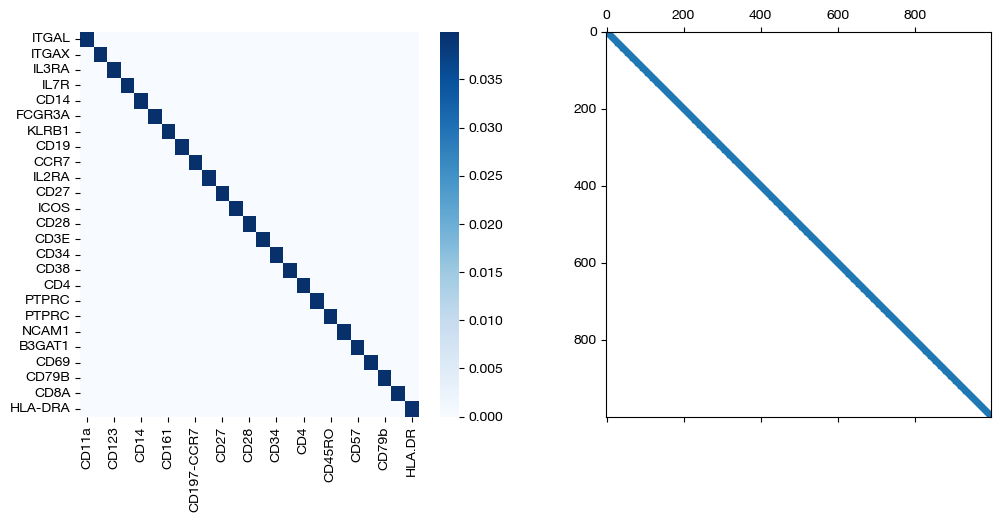

In [15]:
import seaborn as sns

for pi_feat, pi_samp, size in [(pi_feat_sm, pi_samp_sm, 'beta=0.001'), (pi_feat_med, pi_samp_med, 'beta=0.01'), (pi_feat_lg, pi_samp_lg, 'beta=0.1')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), ax=ax1, cmap='Blues')
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

From these matrices, we can see that two perfect $D$ matrices push us towards a perfect alignment in the coupling matrices as $\beta$ increases. As expected from the shape of the $D$ matrices, we get diagonal coupling matrices for larger $\beta$. While we are certain that these D matrices will lead to good alignments in this case (given we have a 1-1 sample mapping and related features), in cases where you might be unsure, try lower $\beta$ to make sure your $D$ matrices aren't pushing your alignments too far in the direction of your less certain prior knowledge. Now, we will visualize the projections of $Y$ onto $X$:

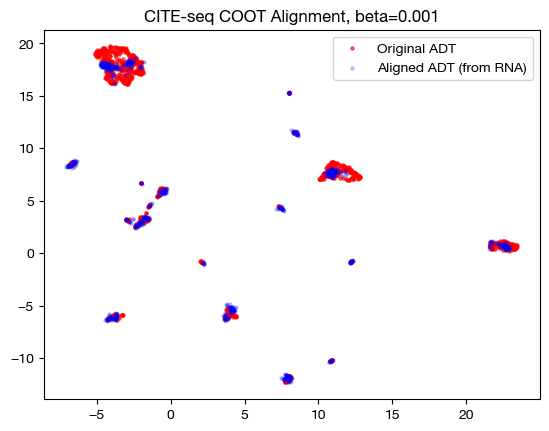

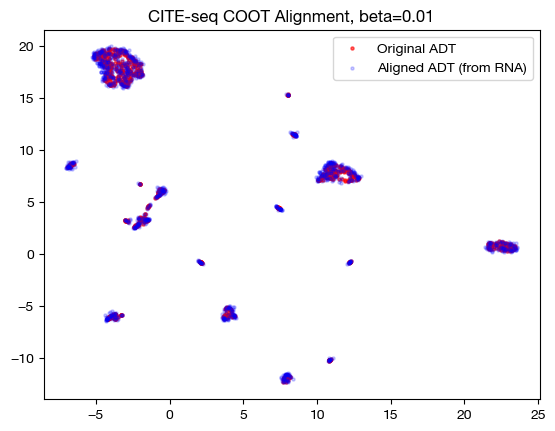

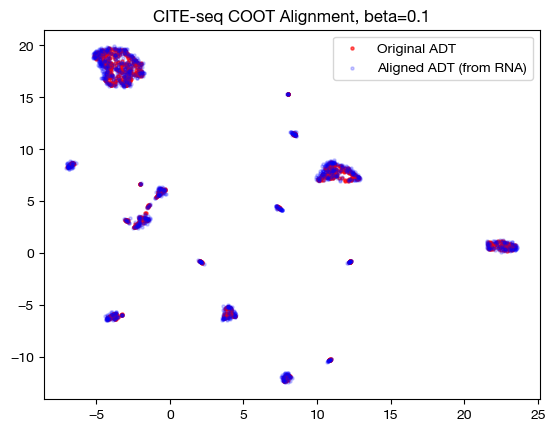

In [16]:
for aligned_rna, size in [(aligned_rna_sm, 'beta=0.001'), (aligned_rna_med, 'beta=0.01'), (aligned_rna_lg, 'beta=0.1')]:    
    aligned_rna_um=adt_um.transform(aligned_rna.numpy())

    plt.scatter(original_adt_um[:,0], original_adt_um[:,1], c="r", s=5, alpha=0.6, label="Original ADT")
    plt.scatter(aligned_rna_um[:,0], aligned_rna_um[:,1], c="b", s=5, alpha=0.2, label="Aligned ADT (from RNA)")
    plt.legend()
    plt.title("CITE-seq COOT Alignment, {0}".format(size))
    plt.show()

Note that the UMAP plots look more and more like a 1-1 mapping as $\beta$ increases, as is consistent with our FOSCTTM and coupling matrix analysis. Now that we understand how $\beta$ and $D$ work together, let's see what they can do in slightly less contrived cases.

### Feature-wise Fused Formulation

In this section, we will try using the same $D$ matrix for the features, but leave the samples unsupervised. In doing so, we will demonstrate that supervision on the feature alignment, if consistent with known biological knowledge, may improve unsupervised sample alignment. In addition to using our more extreme $D_f$ matrix from the first section, we will use one with some cost added along the diagonal.

In [30]:
D_feat_m = torch.from_numpy(D_feat.numpy() + 0.5*np.identity(25, dtype='float32')).to(device)

pi_samp_ft, _, pi_feat_ft = scot.ucoot(rna, adt, eps=1e-3, rho=(1,1), beta=(0, 1), D=(0, D_feat), verbose=False)

pi_samp_ft_m, _, pi_feat_ft_m = scot.ucoot(rna, adt, eps=1e-3, rho=(1,1), beta=(0, 1), D=(0, D_feat_m), verbose=False)

pi_samp_ctrl, _, pi_feat_ctrl = scot.ucoot(rna, adt, eps=1e-3, rho=(1,1), beta=(0, 0), D=(0, 0), verbose=False)

In [31]:
aligned_rna_ft = get_barycentre(adt, pi_samp_ft)
aligned_rna_ft_m = get_barycentre(adt, pi_samp_ft_m)
aligned_rna_ctrl = get_barycentre(adt, pi_samp_ctrl)

With these new alignments, we score and visualize.

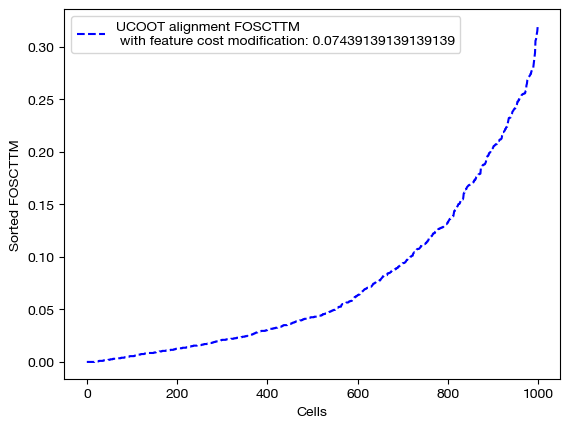

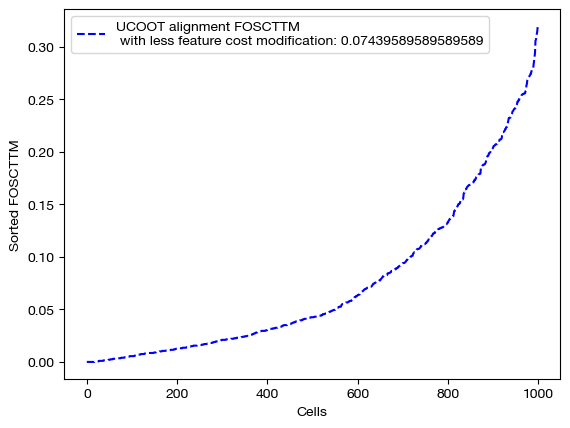

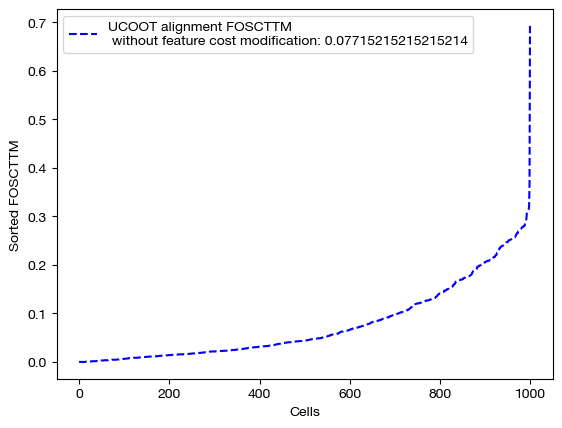

In [32]:
for aligned_rna, d_status in [(aligned_rna_ft, 'with feature cost modification'), (aligned_rna_ft_m, 'with less feature cost modification'), (aligned_rna_ctrl, 'without feature cost modification')]:
    fracs = FOSCTTM(adt, aligned_rna.numpy())
    legend_label="UCOOT alignment FOSCTTM \n {0}: ".format(d_status)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

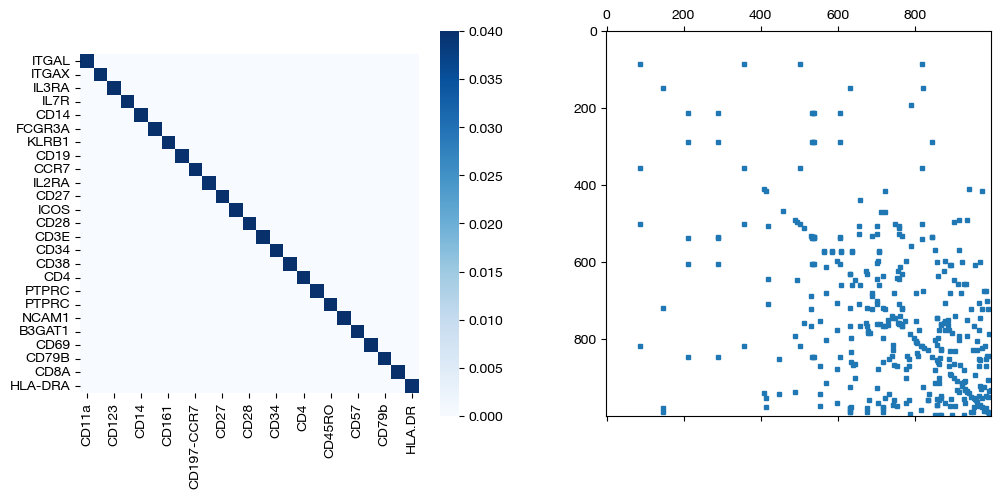

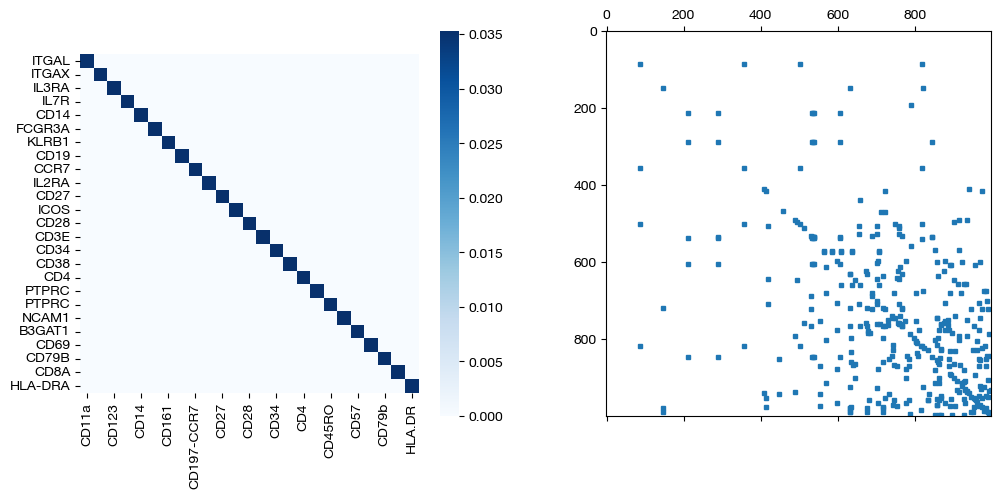

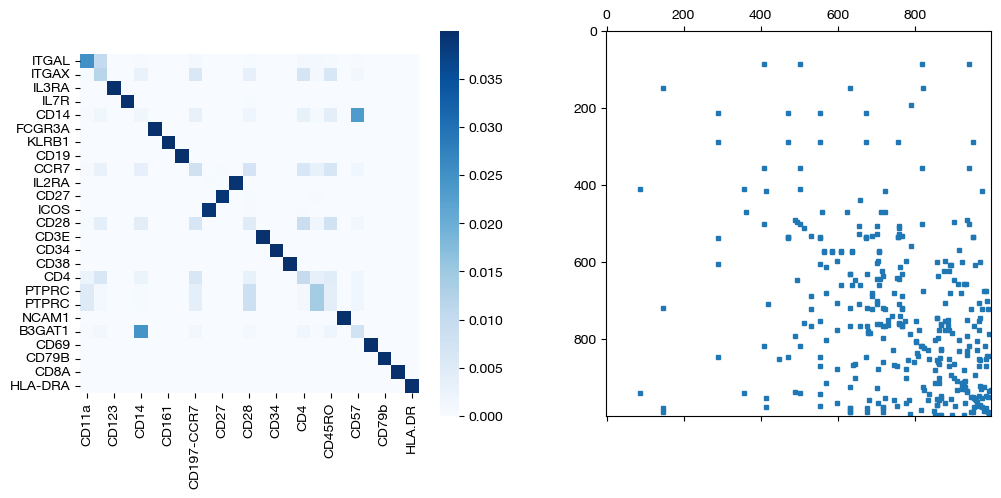

In [37]:
for pi_feat, pi_samp, d_status in [(pi_feat_ft, pi_samp_ft, 'with feature cost modification'), (pi_feat_ft_m, pi_samp_ft_m, 'with less feature cost modification'), (pi_feat_ctrl, pi_samp_ctrl, 'without feature cost modification')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), ax=ax1, cmap='Blues', square=True)
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

As seen above in the FOSCTTM scores and the emerging diagonals in the sampling coupling matrices that received feature superivision, adding feature matrix supervision improves alignment quality.

### Sample-wise Fused Formulation

Now, we will do the same process, except this time, we will include $D_s$ and ignore feature supervision. This kind of procedure is best used when you have some sense of the cell types in your data, or if you already have a good alignment and wish to extract some new information about the features. Here, we will see if sample supervision improves feature coupling.

In [38]:
D_samp_m = torch.from_numpy(D_samp.numpy() + 0.999*np.identity(1000, dtype='float32')).to(device)

pi_samp_smp, _, pi_feat_smp = scot.ucoot(rna, adt, eps=1e-3, rho=(1,1), beta=(1, 0), D=(D_samp, 0), verbose=False)

pi_samp_smp_m, _, pi_feat_smp_m = scot.ucoot(rna, adt, eps=1e-3, rho=(1,1), beta=(1, 0), D=(D_samp_m, 0), verbose=False)

aligned_rna_smp = get_barycentre(adt, pi_samp_smp)
aligned_rna_smp_m = get_barycentre(adt, pi_samp_smp_m)

Now that we have our alignments, we can score the data. Note that we expect perfect alignments when $\beta$ is large enough that the $D$ matrix begins to dominate the transport cost, considering the $D$ matrix encourages the true alignment.

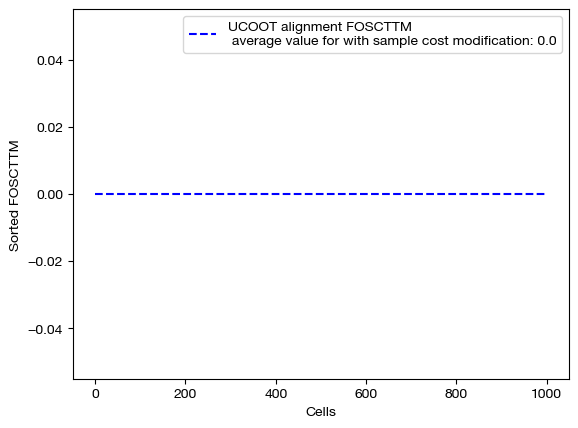

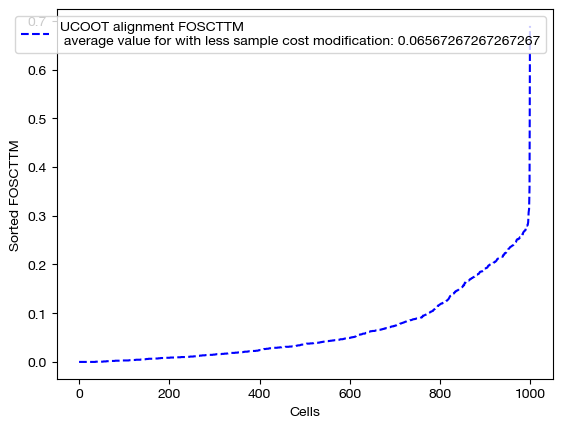

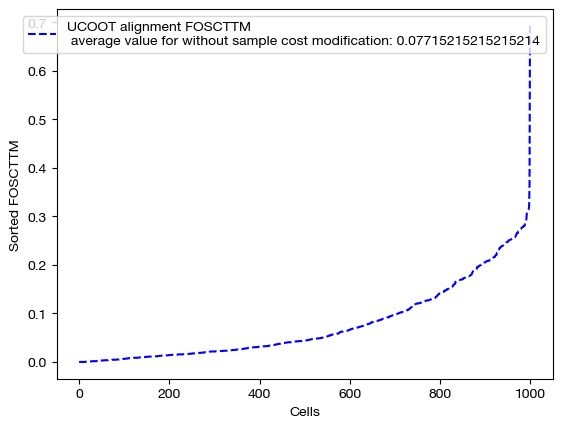

In [40]:
for aligned_rna, d_status in [(aligned_rna_smp, 'with sample cost modification'), (aligned_rna_smp_m, 'with less sample cost modification'), (aligned_rna_ctrl, 'without sample cost modification')]:
    fracs = FOSCTTM(adt, aligned_rna.numpy())
    legend_label="UCOOT alignment FOSCTTM \n average value for {0}: ".format(d_status)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

As expected, we get perfect alignments when we have any sample supervision that encourages the true alignment. However, the truly interesting part of this procedure is seeing how this perfect alignment influenced the feature coupling:

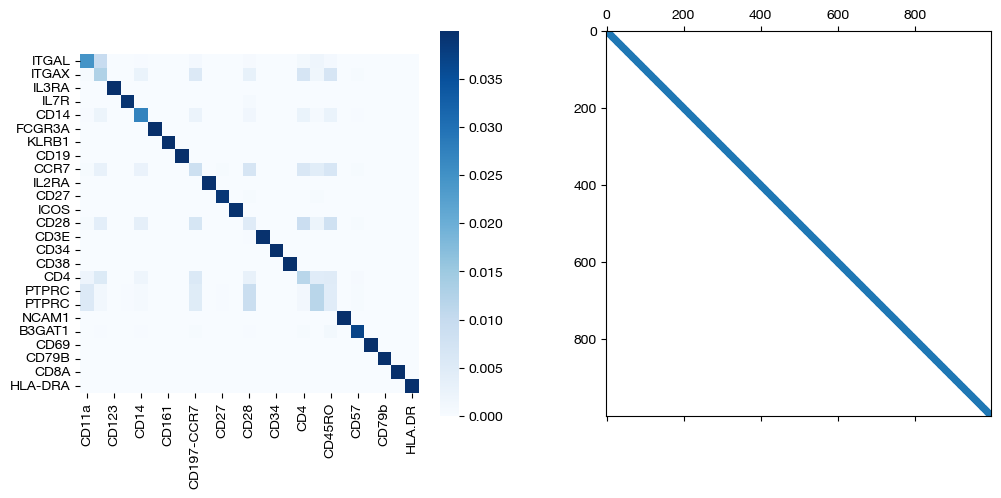

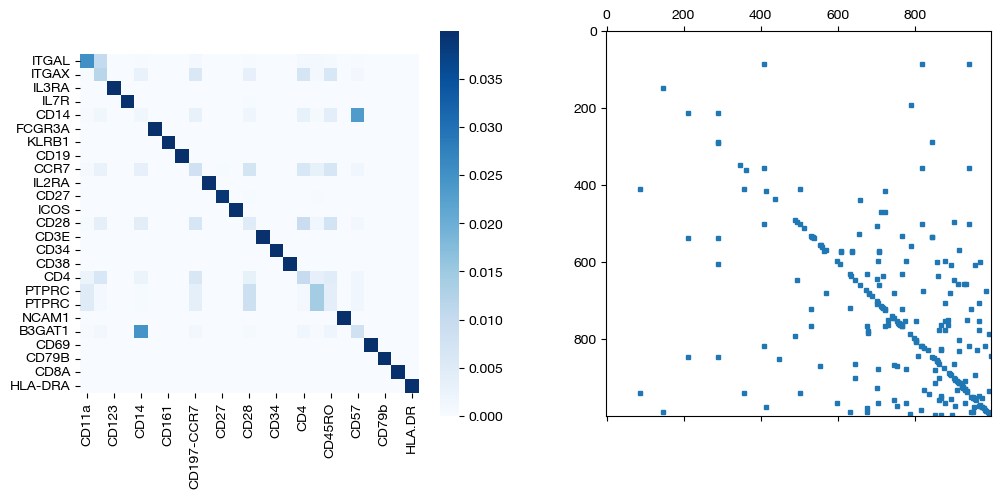

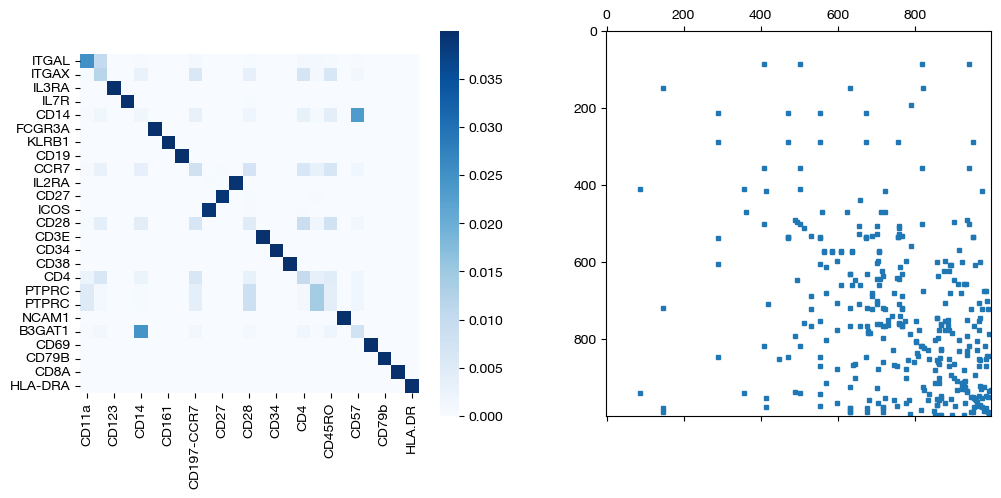

In [41]:
for pi_feat, pi_samp, d_status in [(pi_feat_smp, pi_samp_smp, 'with sample cost modification'), (pi_feat_smp_m, pi_samp_smp_m, 'with less sample cost modification'), (pi_feat_ctrl, pi_samp_ctrl, 'without sample cost modification')]:    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(pi_feat, index=rna.columns, columns=adt.columns), ax=ax1, cmap='Blues', square=True)
    ax2.spy(pi_samp, precision=0.0001, markersize=3)
    plt.show()

As seen above, coupling the samples correctly uncovers the true feature coupling, which was slightly less clear without any sample supervision.

Note that we have been using UCOOT throughout this tutorial, considering that it is a generalization of UGW. All of the same principles apply for UGW, except that UGW only allows for sample supervision (UGW does no feature coupling). Given we expect this tool to primarily be used on separately assayed datasets, UGW will often be fully unsupervised. UCOOT, on the other hand, allows for feature supervision, which we expect to aid sample alignments for separately assayed datasets.

Hopefully, this tutorial has given you some insight into how to use the $D$ and $\beta$ hyperparameters to supervise your alignments. If you have knowledge of cell types or a true alignment among your samples, or some relationship among your features, consider using these supervision matrices. Now, it's time to tie everything we've learned so far together and tackle AGW, which also supports this type of supervision.

Citations:

Quang Huy Tran, Hicham Janati, Nicolas Courty, Rémi Flamary, Ievgen Redko, Pinar Demetci and Ritambhara Singh. Unbalanced CO-Optimal Transport. arXiv, stat.ML, 2023.